<a href="https://colab.research.google.com/github/isegura/OCW-UC3M-NLPDeep-2023/blob/main/tema2_1_cnn_bin_exist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/47/Acronimo_y_nombre_uc3m.png" width=50%/>

<h1><font color='#12007a'>Procesamiento de Lenguaje Natural con Aprendizaje Profundo</font></h1>
<p>Autora: Isabel Segura Bedmar</p>

<img align='right' src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" width=15%/>
</center>      

# 2.1: CNN aplicado a la clasificación binaria de mensajes sexistas.

El objetivo de este problema es entrenar y evaluar un modelo CNN para la clasificación de mensajes sexistas.

El dataset a utilizar es la colección de textos proporcionada por los organizadores de la tareas EXIST 2021. Este dataset puede solicitarse para usos en investigación en el siguiente [link](#http://nlp.uned.es/exist2021/).


Dicho dataset está compuesto por una colección de tweets y comentarios de Gab (conocida por ser una red social de usuarios de extrema derecha). Hay textos tanto en inglés como en español, y han sido anotados para indicar si contienen un mensaje sexista o no. Un texto se considera sexista, si tiene un mensaje sexista, pero también aquellos que están describiendo una situación sexista o están criticando un comportamiento sexista.

- **SEXIST**: Por ejemplo, “Mujer al volante, tenga cuidado!", "El comportamiento de Rubiales ha sido intolerable" (no es un mensaje sexista, pero sí informa sobre un comportamiento sexista).
- **NOT SEXIST**: “Alguien me explica que zorra hace la gente en el cajero que se demora tanto."

El dataset contiene 6.977 tweets para entrenaiento y 3.386 para evaluación. En ambos conjunto, las clases sexist y not sexist están balanceadas.



**NOTA PARA PODER EJECUTAR ESTE NOTEBOOK**:

1) Para poder ejercutar correctamente este notebook, deberás abrirlo en tu Google Drive (por ejemplo, en la carpeta 'Colab Notebooks').

2) Además, debes guardar el dataset en tu Google Drive, dentro de carpeta 'Colab Notebooks/data/exist2021/'.



## Cargar el dataset

Lo primero que debes hacer es cargar el dataset. Como hemos comentado antes, recuerda que para que puedas ejecutar este notebook, deberás haber descargado los ficheros del dataset y haberlos almacenados en tu carpeta 'Colab Notebooks/data/exist2021/' dentro de tu Gooogle Drive.



In [ ]:
from google.colab import drive
# monta tu unidad de google drive
drive.mount('/content/drive')

# cambiamos el directorio de trabajo a la carpeta donde está almacenado el dataset
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/data/exist2021/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cargamos los conjuntos de datos de training y evaluación en dos objetos dataframes de pandas:

In [ ]:
import pandas as pd

df_train = pd.read_csv("train.tsv",  sep='\t')
df_test = pd.read_csv("test.tsv",  sep='\t')

print('tamaño training:', df_train.shape)
print('tamaño test:', df_test.shape)

# mostramos los primeros registros del training:
df_train.head()

tamaño training: (6977, 7)
tamaño test: (4368, 7)


,test_case,id,source,language,text,task1,task2
0,EXIST2021,1,twitter,en,"She calls herself ""anti-feminazi"" how about sh...",sexist,ideological-inequality
1,EXIST2021,2,twitter,en,"Now, back to these women, the brave and the be...",non-sexist,non-sexist
2,EXIST2021,3,twitter,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist,objectification
3,EXIST2021,4,twitter,en,@AurelieGuiboud Incredible! Beautiful!But I l...,non-sexist,non-sexist
4,EXIST2021,5,twitter,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist


El dataset es multilingüe, vamos a quedarnos únicamente con los textos en inglés:

In [ ]:
df_train=df_train[df_train['language']=='en']
df_test=df_test[df_test['language']=='en']
print('tamaño training:', df_train.shape)
print('tamaño test:', df_test.shape)


tamaño training: (3436, 7)
tamaño test: (2208, 7)


La competición EXIST 2021 proponía dos tareas: la clasificación binaria de los comenarios (sexistas y no sexistas) y una multiclasificación de los mensajes sexistas en distintos tipos. En este problema nos centramos en la tarea binaria. Las etiquetas de esta tarea están almacenadas en el campo **task1**. En realidad, únicamente vamos a uilizar los campos **task1** y **task1**. Podemos eliminar el resto de los campos:

In [ ]:
df_train = df_train.drop(['test_case', 'id', 'source', 'task2'], axis=1)
df_test = df_test.drop(['test_case', 'id', 'source', 'task2'], axis=1)
# renombramos task1 a label
df_train = df_train.rename(columns={'task1':'label'})
df_test = df_test.rename(columns={'task1':'label'})
# mostramos los primeros registros del training
df_train.head()

,language,text,label
0,en,"She calls herself ""anti-feminazi"" how about sh...",sexist
1,en,"Now, back to these women, the brave and the be...",non-sexist
2,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist
3,en,@AurelieGuiboud Incredible! Beautiful!But I l...,non-sexist
4,en,i find it extremely hard to believe that kelly...,non-sexist


## Label encoding

Esta tarea consiste en transformar las labels de formato a texto a un formato numérico.

En el caso de clasifición binaria, solo necesitamos transformar las labels de texto a número entero:

- non-sexist -> 0
- sexist -> 1

En nuestra red CNN, la última capa está formada por una única neurona con la función de activación sigmoidea, que devuelve una probabilidad, que se transformará al valor 0 o 1.

Por ese motivo, no necesitamos transformar los etiquetas a categorical (vectores one-hot que presentan cada clase), y simplemente será suficiente con transformarlas a un entero.


In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

y_train = df_train['label'].tolist()
y_test = df_test['label'].tolist()

LABELS = sorted(set(y_train))
# print(LABELS)
idx2label={}
label2idx={}
for index, label in enumerate(LABELS):
    label2idx.update([(label, index)])
    idx2label.update([(index, label)])

# print(idx2label)
print('Labels:', label2idx)
print()

le = LabelEncoder()

print("antes de transform: ", y_train[:10])
y_train = le.fit_transform(y_train)
print("después de transform:", y_train[:10])

print("antes de transform: ", y_test[:10])
y_test = le.transform(y_test)
print("después de transform:", y_test[:10])

#y_train_cat = to_categorical(y_train)
#y_test_cat = to_categorical(y_test)

Labels: {'non-sexist': 0, 'sexist': 1}

antes de transform:  ['sexist', 'non-sexist', 'sexist', 'non-sexist', 'non-sexist', 'sexist', 'non-sexist', 'non-sexist', 'non-sexist', 'non-sexist']
después de transform: [1 0 1 0 0 1 0 0 0 0]
antes de transform:  ['non-sexist', 'non-sexist', 'sexist', 'sexist', 'non-sexist', 'non-sexist', 'non-sexist', 'sexist', 'sexist', 'non-sexist']
después de transform: [0 0 1 1 0 0 0 1 1 0]


## Representación de los textos

Para que los textos puedan ser interpretados por el modelo CNN, necesitan también ser representado en un formato que pueda entender dicho modelo.
En concreto, los tokens son representados como vectores.

Para ello, lo que vamos a hacer es tokenizar los textos con el tokenizador de Keras. Este tokenizador recibe una colección de textos (la colección de entrenamiento) y construye un vocabulario (conjunto de tokens distintos).

El token PAD, que se utiliza en el proceso de padding para conseguir que todas los textos tengan la misma longitud, es almacenado con el índice 0.




In [ ]:
from keras.preprocessing.text import Tokenizer

# guardamos en una lista los textos del training
X_train = df_train['text'].tolist()

tokenizer = Tokenizer(oov_token = True)
# entrenamos el tokenizador usando los textos
tokenizer.fit_on_texts(X_train)

# el índice 0, en principio, no ha sido asignado a ningún token y está reservado
# en nuestro caso, lo usamos para representar el token para padding
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario ={}".format(NUM_WORDS))

Tamaño del vocabulario =16645


El vocabulario consiste de una lista de las palabras de la colección del texto. Todos los signos de puntuación son eliminados.

Vamos a mostrar algunas palabras del vocabulario y su índice.


In [ ]:
for (word,index) in tokenizer.word_index.items():
    print(index,word)
    if index==5:
        break

1 True
2 the
3 to
4 a
5 and


El siguiente paso será aplicar el tokenizador sobre cada uno de los textos. De esta forma, un texto, que no es más que una secuencia de tokens, es represntado como una secuencia de enteros, donde cada entero es el índice del token en el vocabulario.


In [ ]:
# Cada texto es transformado en una secuencia de enteros.
# En el vocabulario, cada palabra tiene asociado un entero
encoded_train = tokenizer.texts_to_sequences(X_train)


Vamos a mostrar el primer texto y su tokenización:

In [ ]:
print(X_train[0])
print(encoded_train[0])

She calls herself "anti-feminazi" how about shut the fucking up on your vile commentary on an elderly responsible citizen tu sach muuch ghani baawri-bewdi hai bey https://t.co/ZMxTDwsY5D
[44, 977, 639, 521, 285, 65, 45, 541, 2, 133, 53, 24, 29, 1348, 3531, 24, 73, 2628, 1163, 5426, 3532, 5427, 5428, 5429, 5430, 5431, 3533, 5432, 16, 13, 14, 5433]


Las redes neuronales necesitan que todas las entradas (en neustro caso textos) tengan el mismo tamaño (en nuestro caso, número de tokens).

Sin embargo, lo más normal es que los textos tengan diferentes tamaños, como se puede ver en la siguiente celda:



In [ ]:
length_train=[len(s) for s in encoded_train]
print(length_train)

[32, 48, 17, 26, 53, 35, 54, 47, 35, 56, 52, 36, 5, 24, 29, 102, 10, 16, 21, 55, 25, 18, 45, 14, 38, 56, 22, 7, 27, 47, 36, 50, 49, 18, 36, 12, 25, 55, 9, 49, 51, 19, 44, 16, 6, 14, 16, 18, 37, 41, 28, 36, 14, 53, 27, 14, 53, 51, 20, 9, 16, 35, 36, 38, 46, 4, 14, 40, 36, 53, 12, 60, 12, 54, 32, 58, 54, 41, 58, 25, 11, 10, 49, 24, 54, 47, 22, 49, 35, 34, 43, 12, 26, 62, 5, 31, 51, 25, 9, 14, 17, 19, 18, 55, 24, 15, 8, 39, 3, 39, 56, 3, 3, 11, 9, 60, 9, 51, 17, 49, 48, 7, 59, 24, 46, 11, 55, 25, 28, 51, 12, 49, 4, 22, 17, 32, 57, 22, 45, 21, 43, 27, 46, 55, 35, 21, 17, 61, 43, 21, 59, 29, 25, 31, 28, 43, 50, 6, 31, 33, 5, 20, 4, 39, 2, 18, 40, 30, 14, 22, 23, 20, 11, 9, 9, 46, 49, 45, 44, 35, 43, 6, 50, 52, 27, 6, 8, 45, 43, 25, 12, 6, 16, 34, 19, 56, 50, 26, 19, 25, 27, 32, 4, 51, 14, 48, 25, 8, 13, 52, 28, 40, 7, 25, 19, 53, 35, 23, 16, 58, 6, 54, 7, 14, 29, 37, 18, 34, 16, 24, 5, 11, 18, 17, 16, 15, 19, 46, 25, 41, 29, 57, 35, 48, 41, 29, 24, 7, 26, 55, 54, 11, 6, 10, 16, 44, 56, 18, 

Vamos a estudiar la distribución de los tamaños en esta colección de textos. Esto nos ayudará a elegir un tamaño lo suficientemente representativo para poder representar todos los textos.


In [ ]:
# Creamos un objeto Series para almacenar dichas longitudes,
df_lengths = pd.Series(length_train)
# el método describe nos permite estudiar su distribución
df_lengths.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])


count    3436.000000
mean       30.281432
std        16.635215
min         2.000000
25%        16.000000
50%        29.000000
75%        45.000000
90%        52.000000
95%        55.000000
99%        61.000000
max       112.000000
dtype: float64

<Axes: >

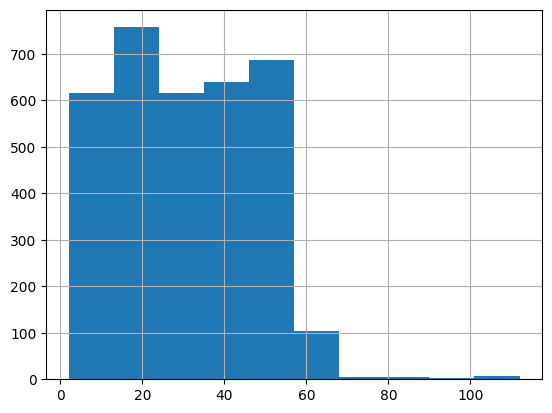

In [ ]:
df_lengths.hist()


El tamaño máximo es de 112 tokens, pero podemos ver que el tamaño medio de los textos es de 30 tokens, y que el 99% de los textos tienen 60 o menos tokens. Por tanto, si elegimos una representación de 112 tokens, estamos desperdiciando mucha memoria.
Si vamos a entrenar con un corpus muy grande, nos interesa utilizar una representación lo más óptima posible para que el rendimiento de la red no se vea afectado.
Un tamaño de 45 tokens o incluso 60, sería suficiente.

Para asegurarnos que todas las secuencias de entrada tengan la misma longitud, utilizaremos el método **pad_sequences**, que lo que hará será:
- padding, si la secuencia de entrada tiene un tamaño menor que el indicado en **MAX_LEN** (en nuestro caso 60). Podemos indicar si el padding se aplicará al inicio de la secuencia (pre) o al final (post). 'pre' es la opción por defecto.
- truncation, si la secuencia tiene una longitud mayor, se eliminarán tokens para que su tamaño sea igual al indicado en **MAX_LEN**. Como en el caso del padding, el proceso **truncating** se puede aplicar al principio (pre, es la opción por defecto) o al final (post) de la secuencia.



In [ ]:
from keras.utils import pad_sequences
MAX_LEN=45
encoded_train_pad = pad_sequences(encoded_train, maxlen = MAX_LEN,
                              padding='post', truncating='post')


Puedes probar con distintas opciones de los argumentos de la función pad_sequences, para estudiar su efecto sobre la secuencias procesadas.

In [ ]:
print(encoded_train_pad[0])
print(encoded_train[0])
print(X_train[0])


[  44  977  639  521  285   65   45  541    2  133   53   24   29 1348
 3531   24   73 2628 1163 5426 3532 5427 5428 5429 5430 5431 3533 5432
   16   13   14 5433    0    0    0    0    0    0    0    0    0    0
    0    0    0]
[44, 977, 639, 521, 285, 65, 45, 541, 2, 133, 53, 24, 29, 1348, 3531, 24, 73, 2628, 1163, 5426, 3532, 5427, 5428, 5429, 5430, 5431, 3533, 5432, 16, 13, 14, 5433]
She calls herself "anti-feminazi" how about shut the fucking up on your vile commentary on an elderly responsible citizen tu sach muuch ghani baawri-bewdi hai bey https://t.co/ZMxTDwsY5D


## CNN

Una vez que ya hemos procesado el texto, podemos definir el modelo.



In [ ]:
import tensorflow as tf
# asegurar que los experimentos se pueden reproducir
tf.random.set_seed(42)
tf.__version__

'2.13.0'

### Crear el modelo
Vamos a utilizar keras, que es una interfaz que nos facilita crear una arquitectura. En concreto, el modelo será un objeto de la clase **Sequential**, porque vamos a añadir varias capas de forma secuencial:

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

model = Sequential()


La primera capaz es la capaz de embeddings, que se encargará de representar cada texto como una matriz de vectores. La matriz tendrá como número de filas el valor de la variable **MAX_LEN**, es decir, la longitud de las secuencias de entrada. Como número de columnas, tendremos que decidir que dimensión queremos utilizar para represntar los vectores de los tokens. En este ejemplo, vamos a utilizar 50, pero podríamos probar con otras dimensiones como 100, 200 o 300 (son las más utilizadas).

La capa **Embedding** lo que hará será inicializar una matriz por cada texto. Como se ha dicho antes la matriz, tendrá una dimensión de MAX_LEN x EMBEDDING_SIZE.

En este ejercicio, la matriz se inicializa con pesos aleaotorios, pero en el tema 4, aprenderemos a inicializar la matriz a partir de un modelo pre-entrenado de word embeddings.


In [ ]:
EMBEDDING_SIZE=50 #probar con 200, 300
model.add(Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=MAX_LEN))


A continuación, ya podemos añadir las capas características de esta arquitectura: convolucional y pooling.

En nuestro ejemplo, vamos a añadir tres niveles de convolución acompañado de una capaz max-pooling.

Para textos, la capa convolucional se crea con la clase **Conv1D**.

En cada capa de convolución, debemos indicar el número de filtros (a mayor número de filtros, mayor capacidad de representación, pero también mayor coste computacional), y el tamaño del kernel (tamaño de la ventana que se desplaza por la entrada).

En la capa convolucional además podemos indicar cómo se aplicará el padding. "SAME" intenta rellenar uniformemente hacia la izquierda y hacia la derecha, pero si la cantidad de columnas que se añaden es impar, agregará la adicional a la derecha.



REspecto a la capa de max-pooling, usamos pool-size = 2, que significa que de la salida de la capa convolucional, tomará los dos elementos mayores.


Para determinar el  número óptimo de filtros y su tamaño, el tamaño de la capa de max-pooling, así cómo de otros parámetros, es recomendable realizar varios experimentos.


In [ ]:

model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))


A continuación, ya podemos añadir otras capas como una capa Densa (suelen mejorar los resultados de clasificación).
La última capa usa la función sigmoid y devuelve una probabilidad. Si la probabilidad es cercana a 1, la capa devuelve 1, y 0 en otro caso.


In [ ]:

model.add(Flatten())
model.add(Dense(50, activation='relu'))
# Para clasificación binaria
model.add(Dense(1, activation='sigmoid'))


Finalmente, debemos compilar el modelo, indicando el optimizador, la función de error y las métricas que se utilizarán en cada epoch.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 50)            832250    
                                                                 
 conv1d (Conv1D)             (None, 45, 128)           25728     
                                                                 
 max_pooling1d (MaxPooling1  (None, 22, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 64)            24640     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 11, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 32)            4

### Entrenar el modelo

Para entrenar el modelo, simplemente tenemes que llamar al método **fit** del modelo. Este método recibe como argumentos:
- los textos preprocesados y almacenados en la variable **encoded_train_pad**, y sus labels correspondientes, que el modelo utilizará para medir el error y aprender.
- el número de epochs y el tamaño del batch. En este ejercicio, utilizaremos 10 epochs y un tamaño de batch de 16. Sin embargo, deberías probar con diferentes valores para ver cuáles proporcionan los mejores resultados.

- Como no tenemos un conjunto de validación explícito, en el método **fit** (para entrenar el modelo) específicamos usando el argumento **validation_split** qué porcentaje del training vamos a usar como conjunto de validación.

- Además, también vamos a usar **EarlyStopping** que nos permitirá parar el entrenamiento si después de 3 epochs (**patience**), el error sobre el conjunto de valiación no ha disminuido.


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Para el entrenamiento después de 3 epochs sin el error en el conjunto de validación no mejora
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')


Al ejecutar la siguiente celda, podemos ver el proceso de entrenamiento y qué resultados se obtienen en cada epoch sobre el conjunto de validación:

In [ ]:
epochs = 10
batch_size = 16

# training
history=model.fit(encoded_train_pad,  # textos preprocesados
                  y_train,          # labels
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=[earlyStopping],
                  )


Epoch 1/10
172/172 [==============================] - 14s 43ms/step - loss: 0.6924 - accuracy: 0.5215 - val_loss: 0.6954 - val_accuracy: 0.4985
Epoch 2/10
172/172 [==============================] - 8s 46ms/step - loss: 0.6006 - accuracy: 0.6783 - val_loss: 0.5997 - val_accuracy: 0.6831
Epoch 3/10
172/172 [==============================] - 7s 39ms/step - loss: 0.2461 - accuracy: 0.9098 - val_loss: 0.7784 - val_accuracy: 0.6541
Epoch 4/10
172/172 [==============================] - 8s 47ms/step - loss: 0.0641 - accuracy: 0.9822 - val_loss: 1.1517 - val_accuracy: 0.6672
Epoch 5/10
172/172 [==============================] - 6s 36ms/step - loss: 0.0178 - accuracy: 0.9956 - val_loss: 1.3982 - val_accuracy: 0.6439


El entrenamiento se detiene en la epoch 5.

### Curvas de aprendizaje

Estos gráficos nos permiten ver cómo el modelo aprende a lo largo de su entrenamiento, en concreto, muestran sus resultados al ser evaluados en cada epoch sobre su conjunto de entrenamiento y el conjunto de validación. Se pueden mostrar gráficos distintos para el acuracy y para el error (su comportamiento será opuesto).

Estas curvas se utilizan para diagnosticar un modelo que no es capaz de resolver la tarea, que sufre de sobre-aprendizaje (se ajusta perfecgtamente al conjunto de entrenamiento, pero no es capaz de resolver el problema en el conjunto de validación), o si el modelo está bien ajustado.




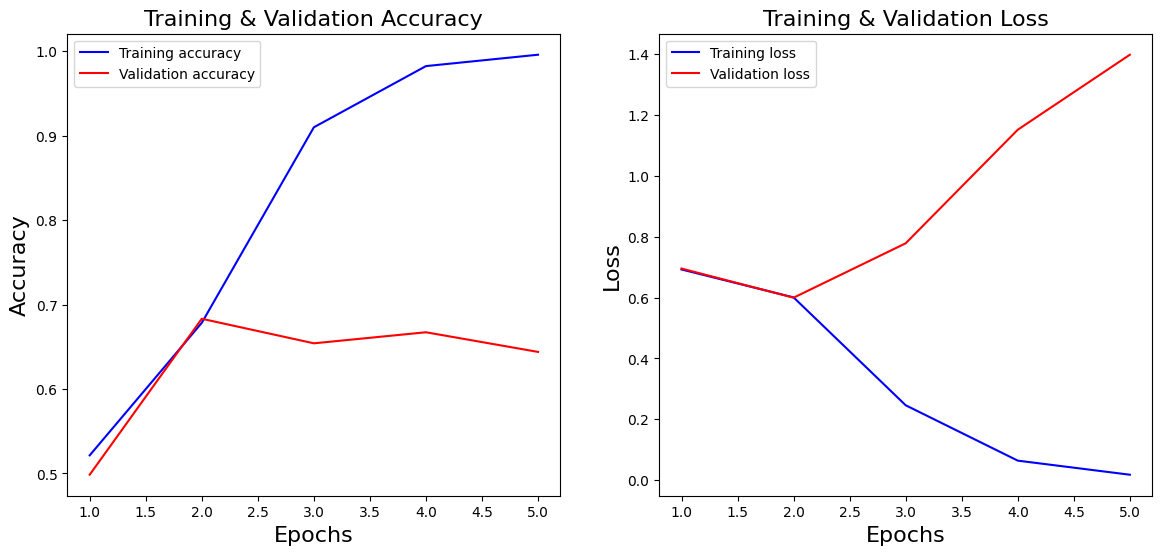

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Curva accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Curva loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

Si nos fijamos en las curva del error, mientras que la curva del entrenamiento se aproxima a 0, el error en la validación aumenta. Esto significa que el modelo no ha aprendido a resolver el problema.
Por tanto, será necesario utilizar más datos y además, investigar en un modelo más complejo que sea capaz de resolver la tarea.

Idealmente, ambas curvas loss deberían tender a 0. Ese caso significa que el modelo es capaz de generalizar y resolve la tarea en el conjunto de validación.

### Evaluar el modelo



Aunque las curvas de aprendizaje nos dicen que deberíamos seguir investigando en mejorar el modelo, vamos a evaluarlo sobre el conjunto test. En primer lugar, vamos a obtener las métricas loss y  accuracy en dicho conjunto (que no ha sido utilizado en ninguna fase del entrenamiento).

In [ ]:
X_test = df_test['text'].tolist()
encoded_test = tokenizer.texts_to_sequences(X_test)
encoded_test = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

loss, accuracy = model.evaluate(encoded_test, y_test, batch_size=batch_size)


138/138 [==============================] - 1s 6ms/step - loss: 1.6389 - accuracy: 0.6264


Es un acuracy bastante bajo (62%)

Es posible obtener una evaluación más detallada con las métricas de precisión, recall y F1, gracias a la librería sklearn:

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# generamos las prediciones del modelo sobre el conjunto test
y_pred = np.round(model.predict(encoded_test))

print('accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=LABELS))


69/69 [==============================] - 1s 12ms/step
accuracy: 0.626358695652174
              precision    recall  f1-score   support

  non-sexist       0.63      0.53      0.57      1050
      sexist       0.63      0.72      0.67      1158

    accuracy                           0.63      2208
   macro avg       0.63      0.62      0.62      2208
weighted avg       0.63      0.63      0.62      2208



La F1 de la clase positiva (sexist) no supera el 67%.

[[553 497]
 [328 830]]


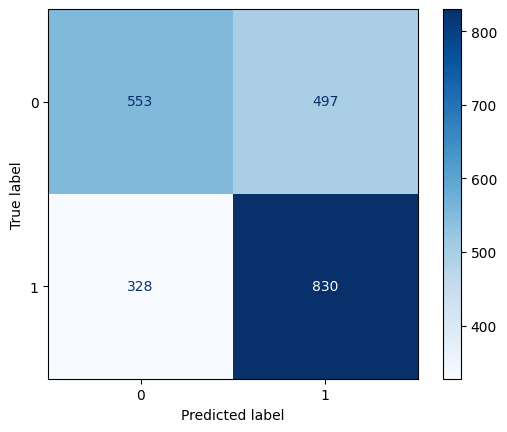

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_test, y_pred))
disp=ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)


El modelo clasifica correctamente un alto número de mensajes  sexistas (830 de un total de 1158). Sin embargo, de los 1050 mensajes no sexistas, el modelo únicamente es capaz de clasificar correctamente la mitad (553). El resto (1462) lo está clasificando como sexistas.
Por tanto, el modelo está generando muchos falsos positivos (muchos mensajes sexistas son incorrectamente clasificados como no sexistas).

Prueba con otras configuraciones de capas convolucionales y maxpooling.
Además, también es recomendable que pruebes con un número distinto de epochs y batch y que modifiques el proceso de EarlyStopping.